In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# '''
# Desc:  apply the ARIMA model, on NINO 3.4 Index monthly data.
# DataSource: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/
# Reference:
# https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# Author: Kris Peng
# Date: 2018/07/19
# '''

In [1]:
import warnings
from pandas import read_csv
from pandas import DataFrame
from pandas import TimeGrouper
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
import itertools
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.style.use('fivethirtyeight')


/Users/chengpeng/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


count    1776.000000
mean       -0.104054
std         0.772745
min        -2.490000
25%        -0.630000
50%        -0.160000
75%         0.330000
max         2.570000
dtype: float64


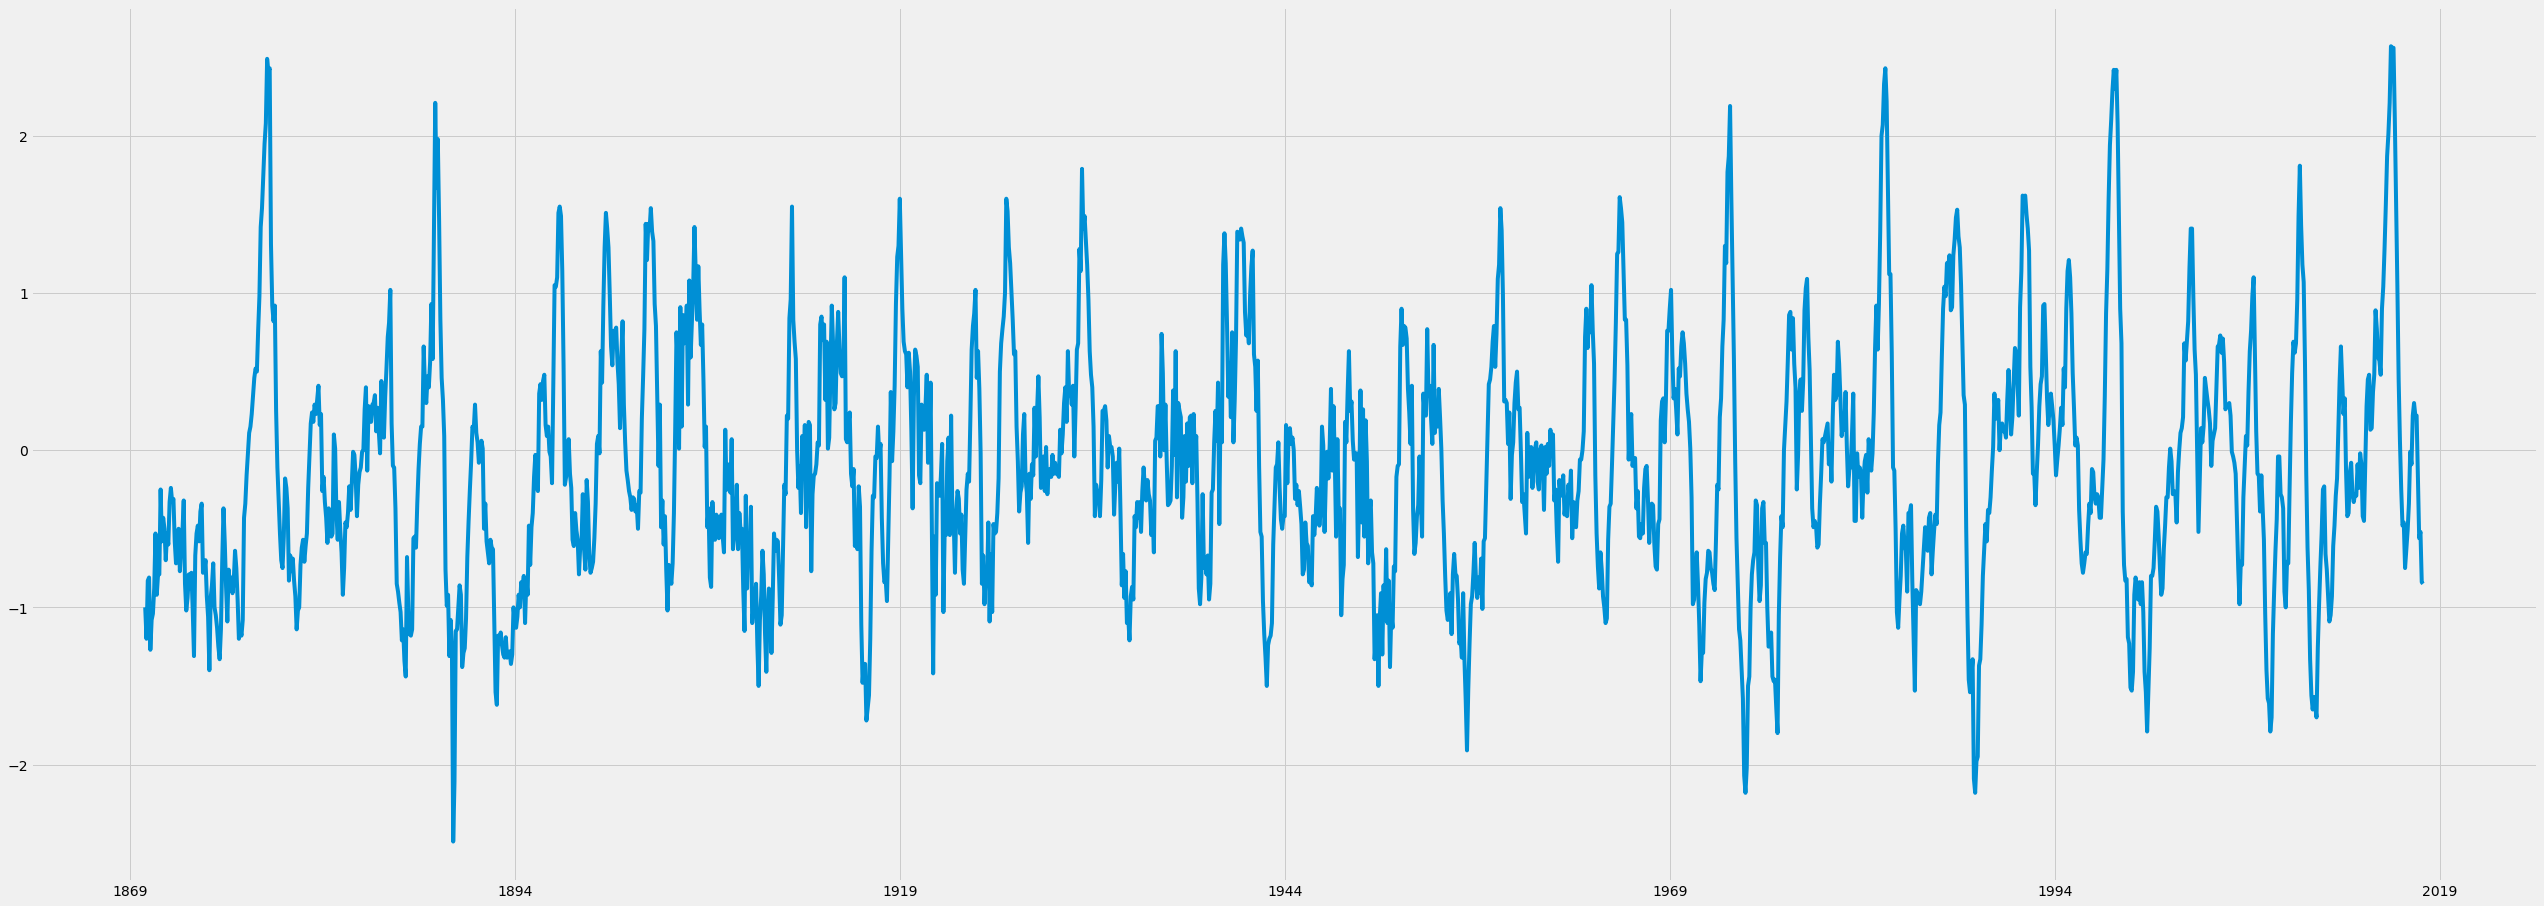

In [3]:
series = Series.from_csv('../../data/oni/csv/nino34_anomaly.csv')
print(series.describe())

series.plot(figsize=(40, 15))
plt.show()

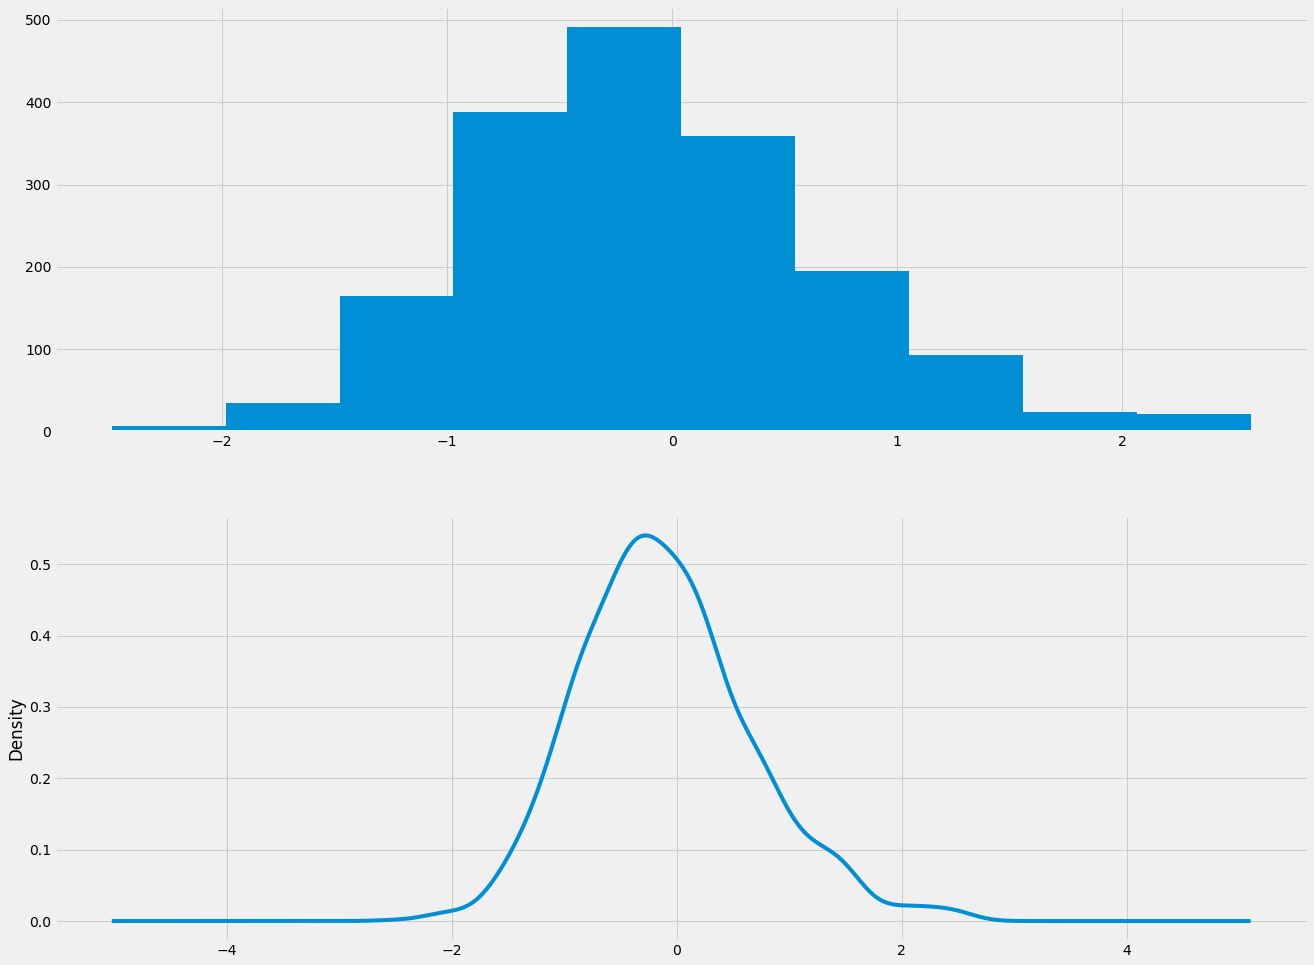

In [4]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde', figsize=(20, 16))
plt.show()

/Users/chengpeng/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


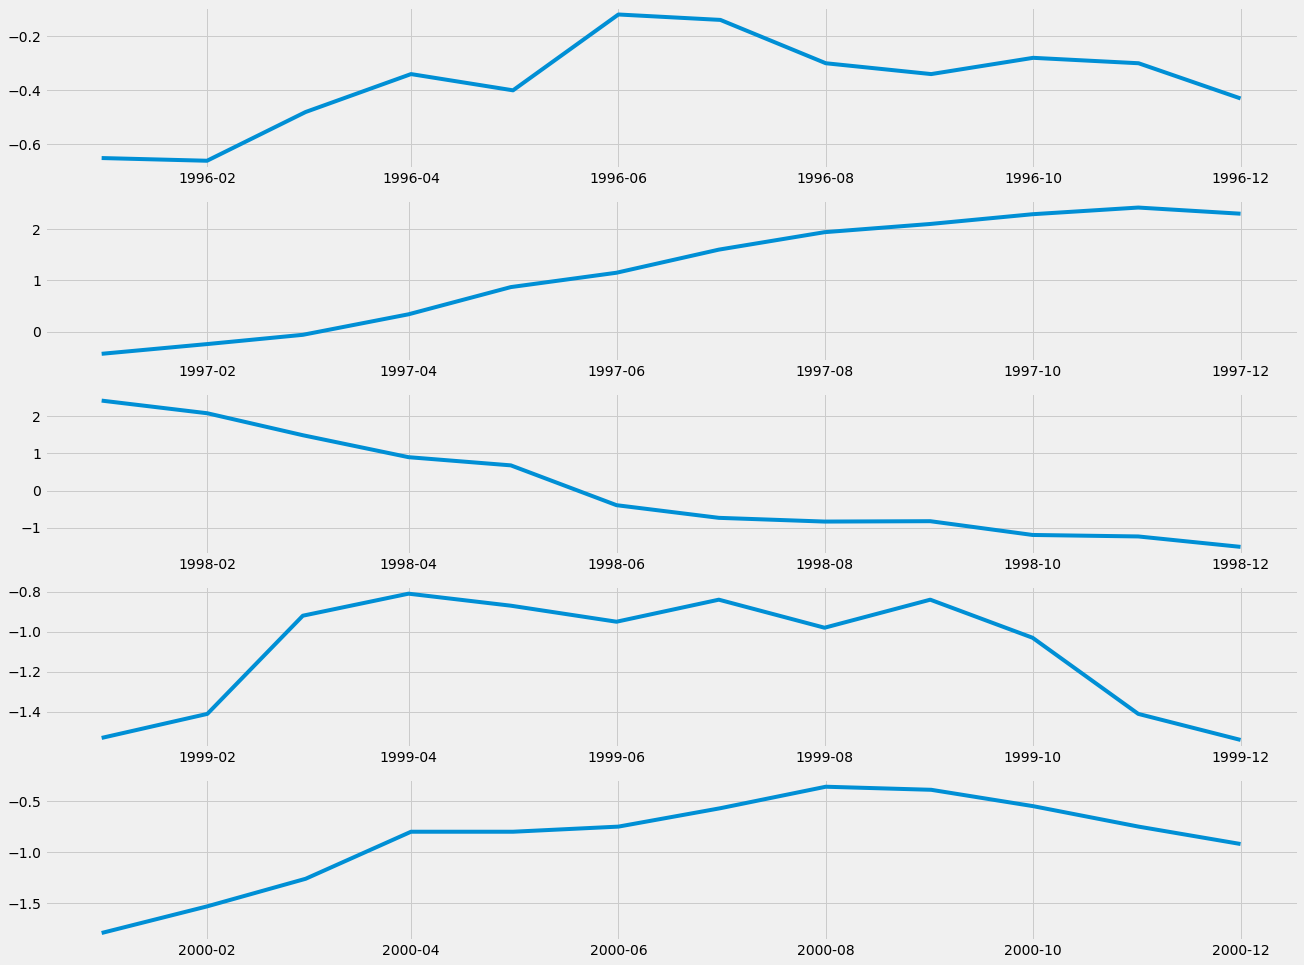

In [43]:
# Data Analysis

groups = series['1996':'2000'].groupby(TimeGrouper('A')) # random years
years = DataFrame()
plt.figure(figsize=(20, 16))
i=1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

/Users/chengpeng/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


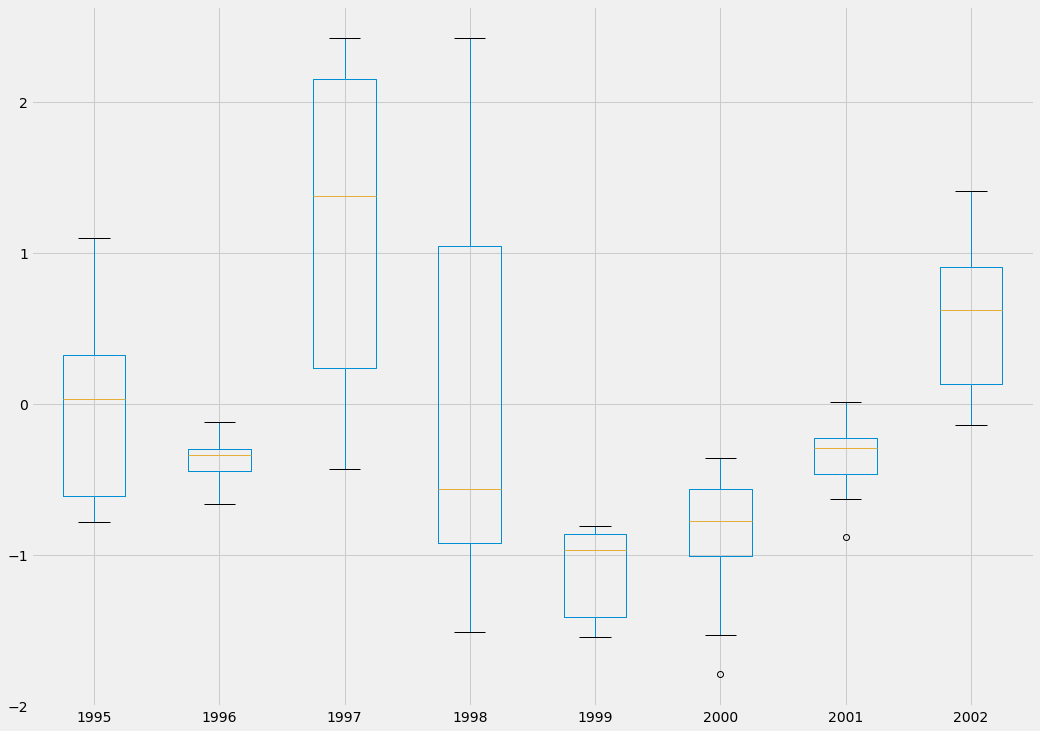

In [49]:
plt.figure(figsize=(16, 12))
groups = series['1995':'2002'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

ADF Statistic: -9.311799
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


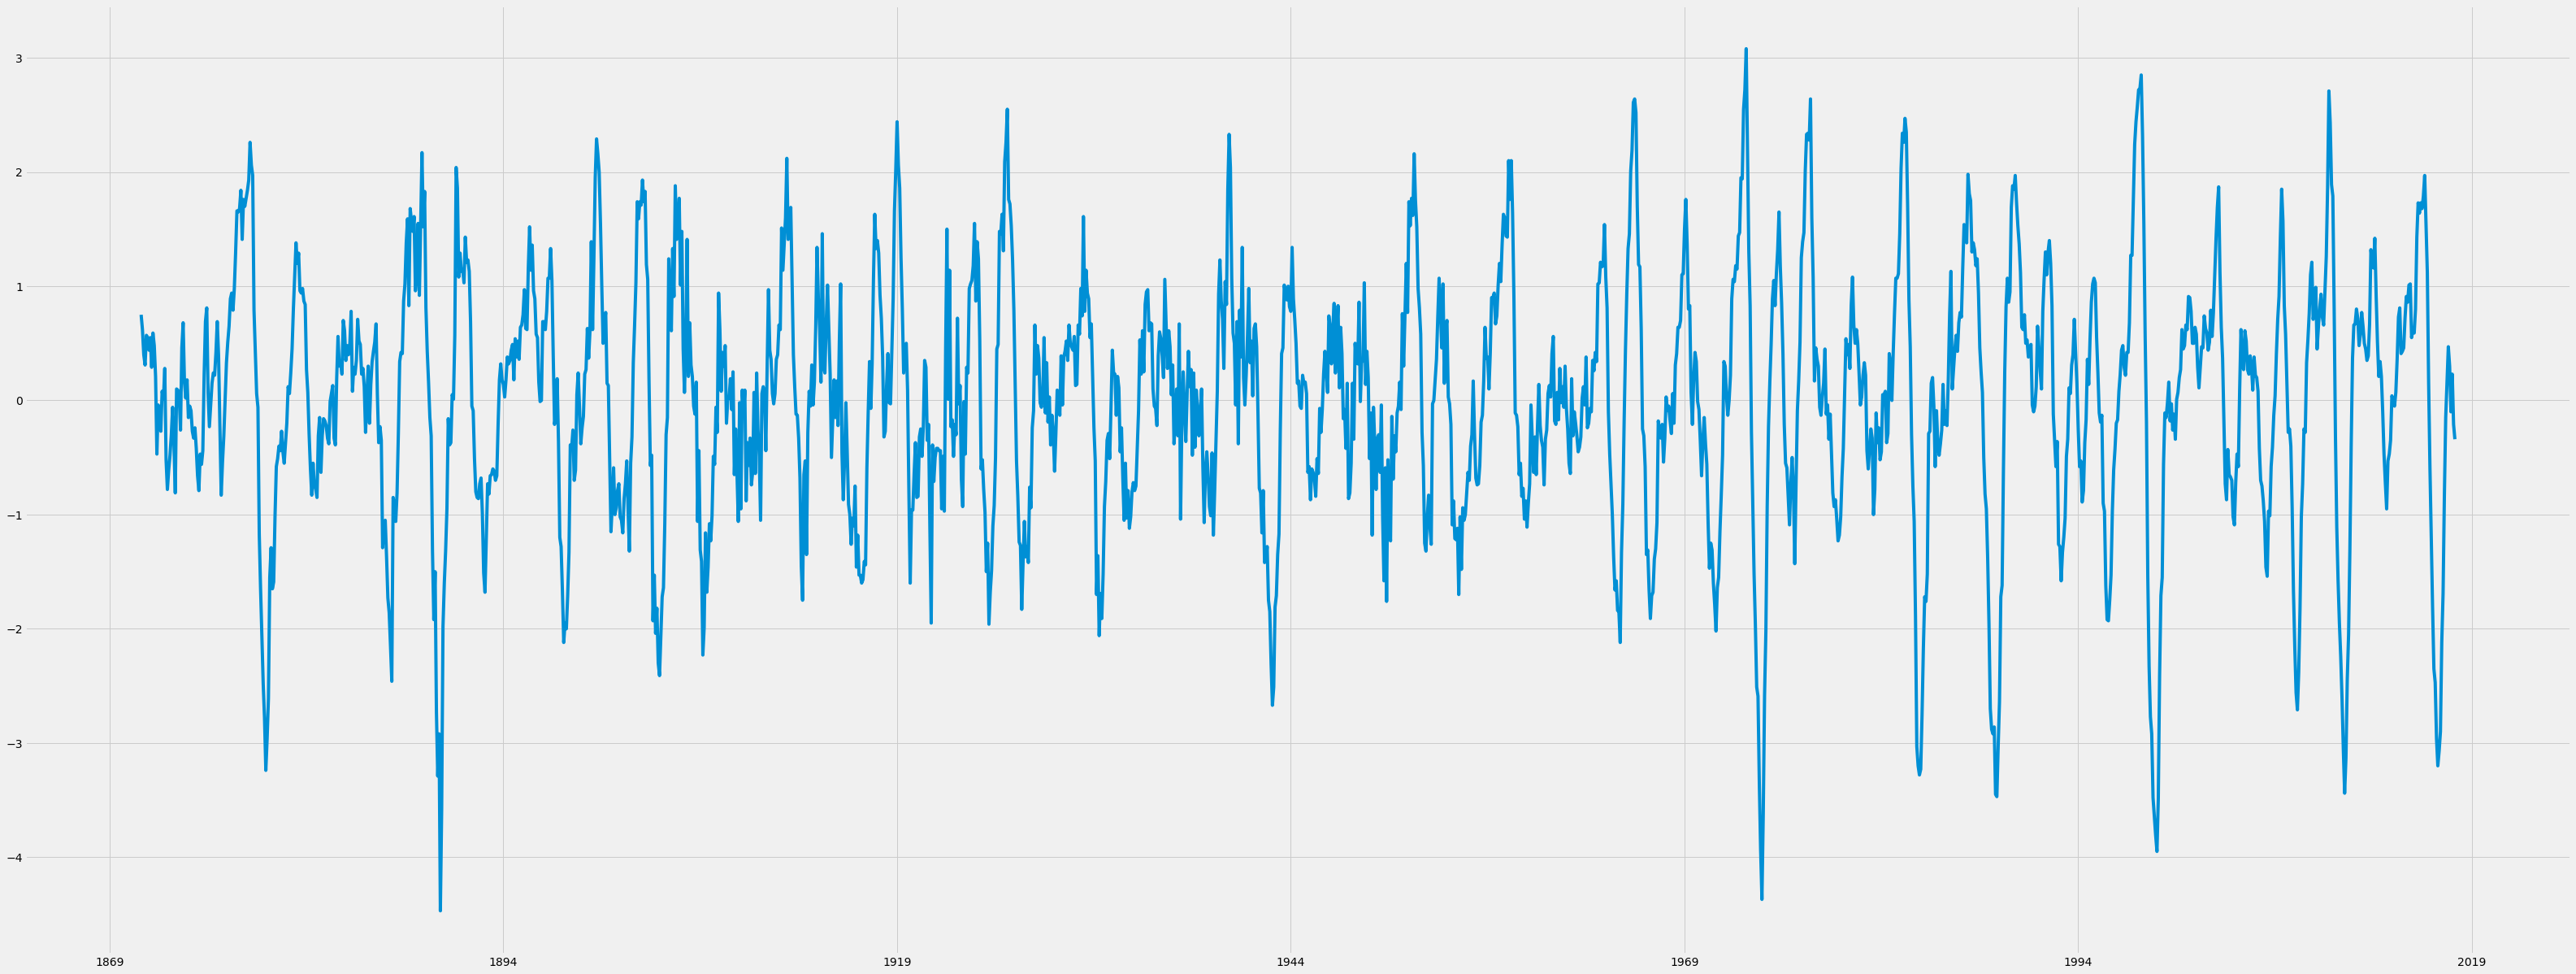

In [8]:
# create a differenced series, lose the first year data
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f'  % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print( '\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
plt.figure(figsize=(50, 20))
stationary.plot()
plt.show()

/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


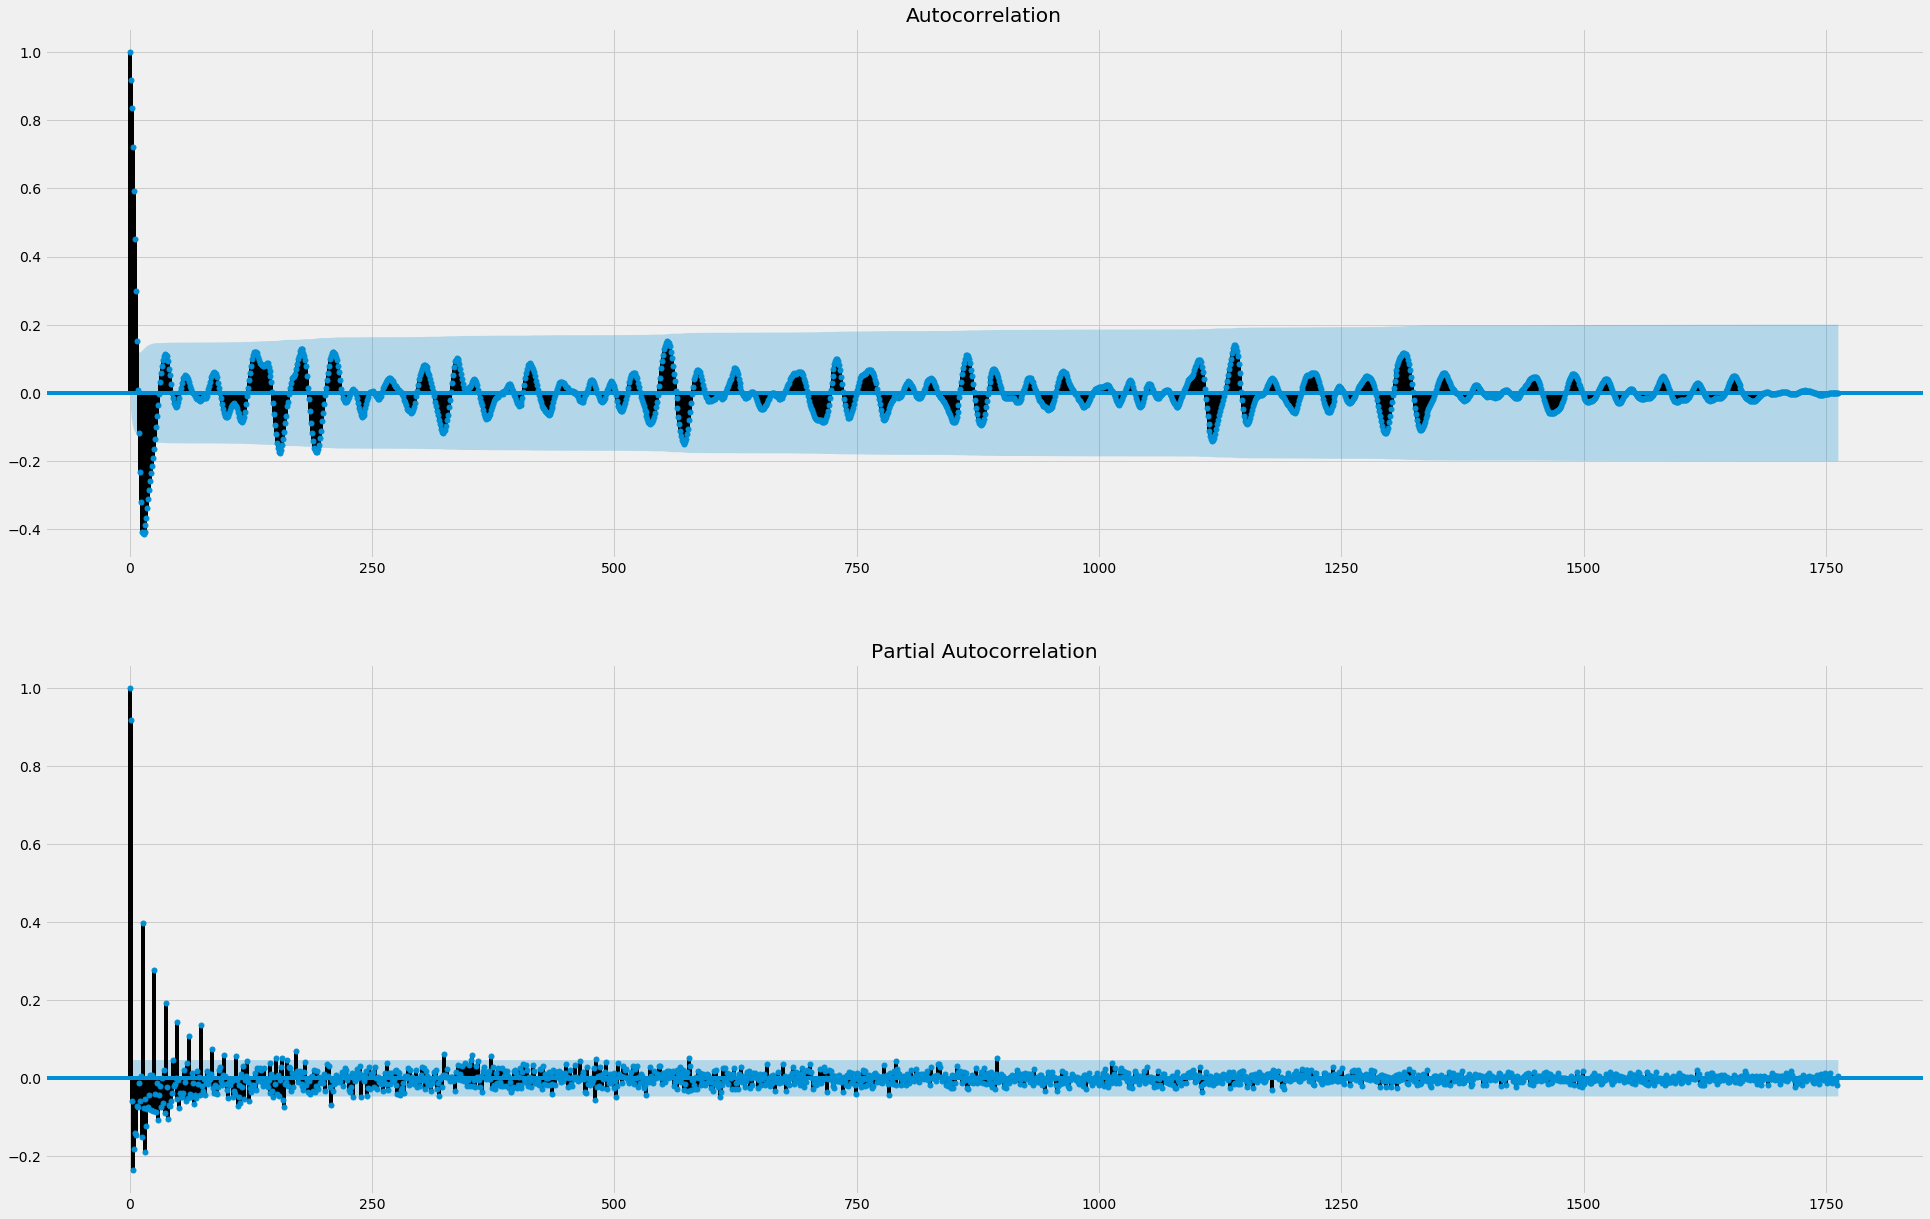

In [77]:
series = Series.from_csv('stationary.csv')
plt.figure(figsize=(30, 20))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [2]:
# ARIMA Model

# create a differenced series, lose the first year data
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('../../data/oni/csv/nino34_anomaly.csv')
# prepare data

print(series.describe())
# X = series.values
# X = X.astype('float32')

train, test = series[0:-360], series[-360:len(series)]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
#   months_in_year = 12
#   diff = difference(history, months_in_year)
    # predict
    
    model = ARIMA(history, order=(11,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
#   yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print( '>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print( 'RMSE: %.3f'  % rmse)

/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


count    1776.000000
mean       -0.104054
std         0.772745
min        -2.490000
25%        -0.630000
50%        -0.160000
75%         0.330000
max         2.570000
dtype: float64
>Predicted=1.069, Expected=0.690
>Predicted=0.700, Expected=0.350
>Predicted=0.311, Expected=0.290
>Predicted=0.205, Expected=-0.490
>Predicted=-0.458, Expected=-1.050
>Predicted=-1.085, Expected=-1.460
>Predicted=-1.467, Expected=-1.540
>Predicted=-1.559, Expected=-1.440
>Predicted=-1.454, Expected=-1.330
>Predicted=-1.285, Expected=-2.090
>Predicted=-1.917, Expected=-2.180
>Predicted=-2.105, Expected=-1.980
>Predicted=-1.897, Expected=-1.950
>Predicted=-1.840, Expected=-1.370
>Predicted=-1.373, Expected=-1.330
>Predicted=-1.229, Expected=-1.110
>Predicted=-1.074, Expected=-0.800
>Predicted=-0.738, Expected=-0.640
>Predicted=-0.573, Expected=-0.470
>Predicted=-0.405, Expected=-0.580
>Predicted=-0.553, Expected=-0.380
>Predicted=-0.454, Expected=-0.400
>Predicted=-0.424, Expected=-0.300
>Predicted=-0.398, 

KeyboardInterrupt: 

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
    train, test = series[0:-360], series[-360:len(series)]
    history = [x for x in train]
  # make predictions
    predictions = list()
    for t in range(len(test)):
    # difference data
#         months_in_year = 12
#         diff = difference(history, months_in_year)
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
#         yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f'  % (order,rmse))
                except:
                    continue
    print( 'Best ARIMA%s RMSE=%.3f'  % (best_cfg, best_score))
# load dataset
series = Series.from_csv('../../data/oni/csv/nino34_anomaly.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
# todo
q_values = range(6, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


                0
count  360.000000
mean    -0.003716
std      0.245626
min     -0.821484
25%     -0.165474
50%     -0.002329
75%      0.160516
max      0.694084


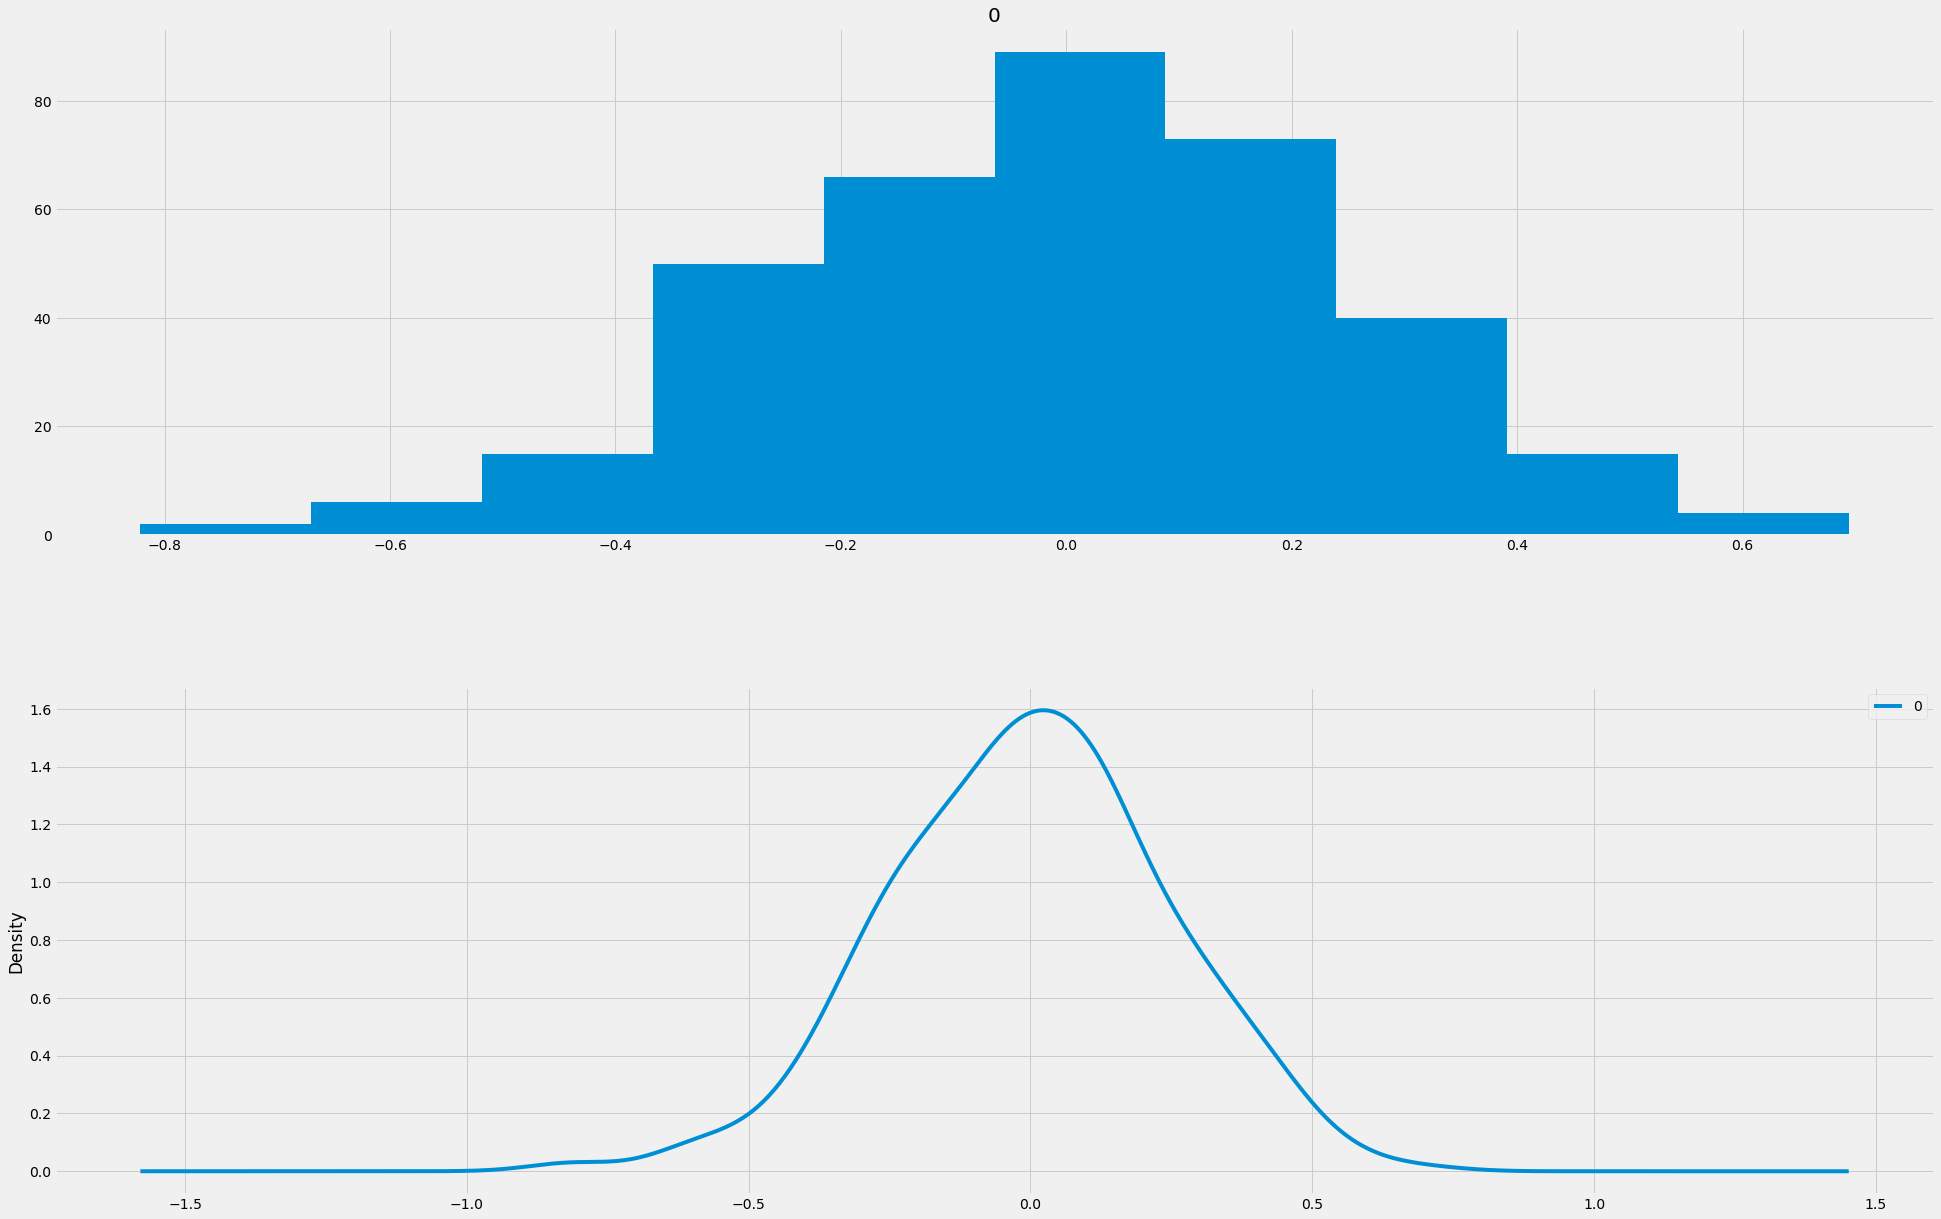

In [9]:
# residual error analysis, using(p,d,q) --> (5,0,3)

series = Series.from_csv('../../data/oni/csv/nino34_anomaly.csv')
train, test = series[0:-360], series[-360:len(series)]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    # months_in_year = 12
    # diff = difference(history, months_in_year)
    # predict
    model = ARIMA(history, order=(5,0,3))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    # yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
#     print( 'Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    history.append(obs)
    
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure(figsize=(30, 20))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

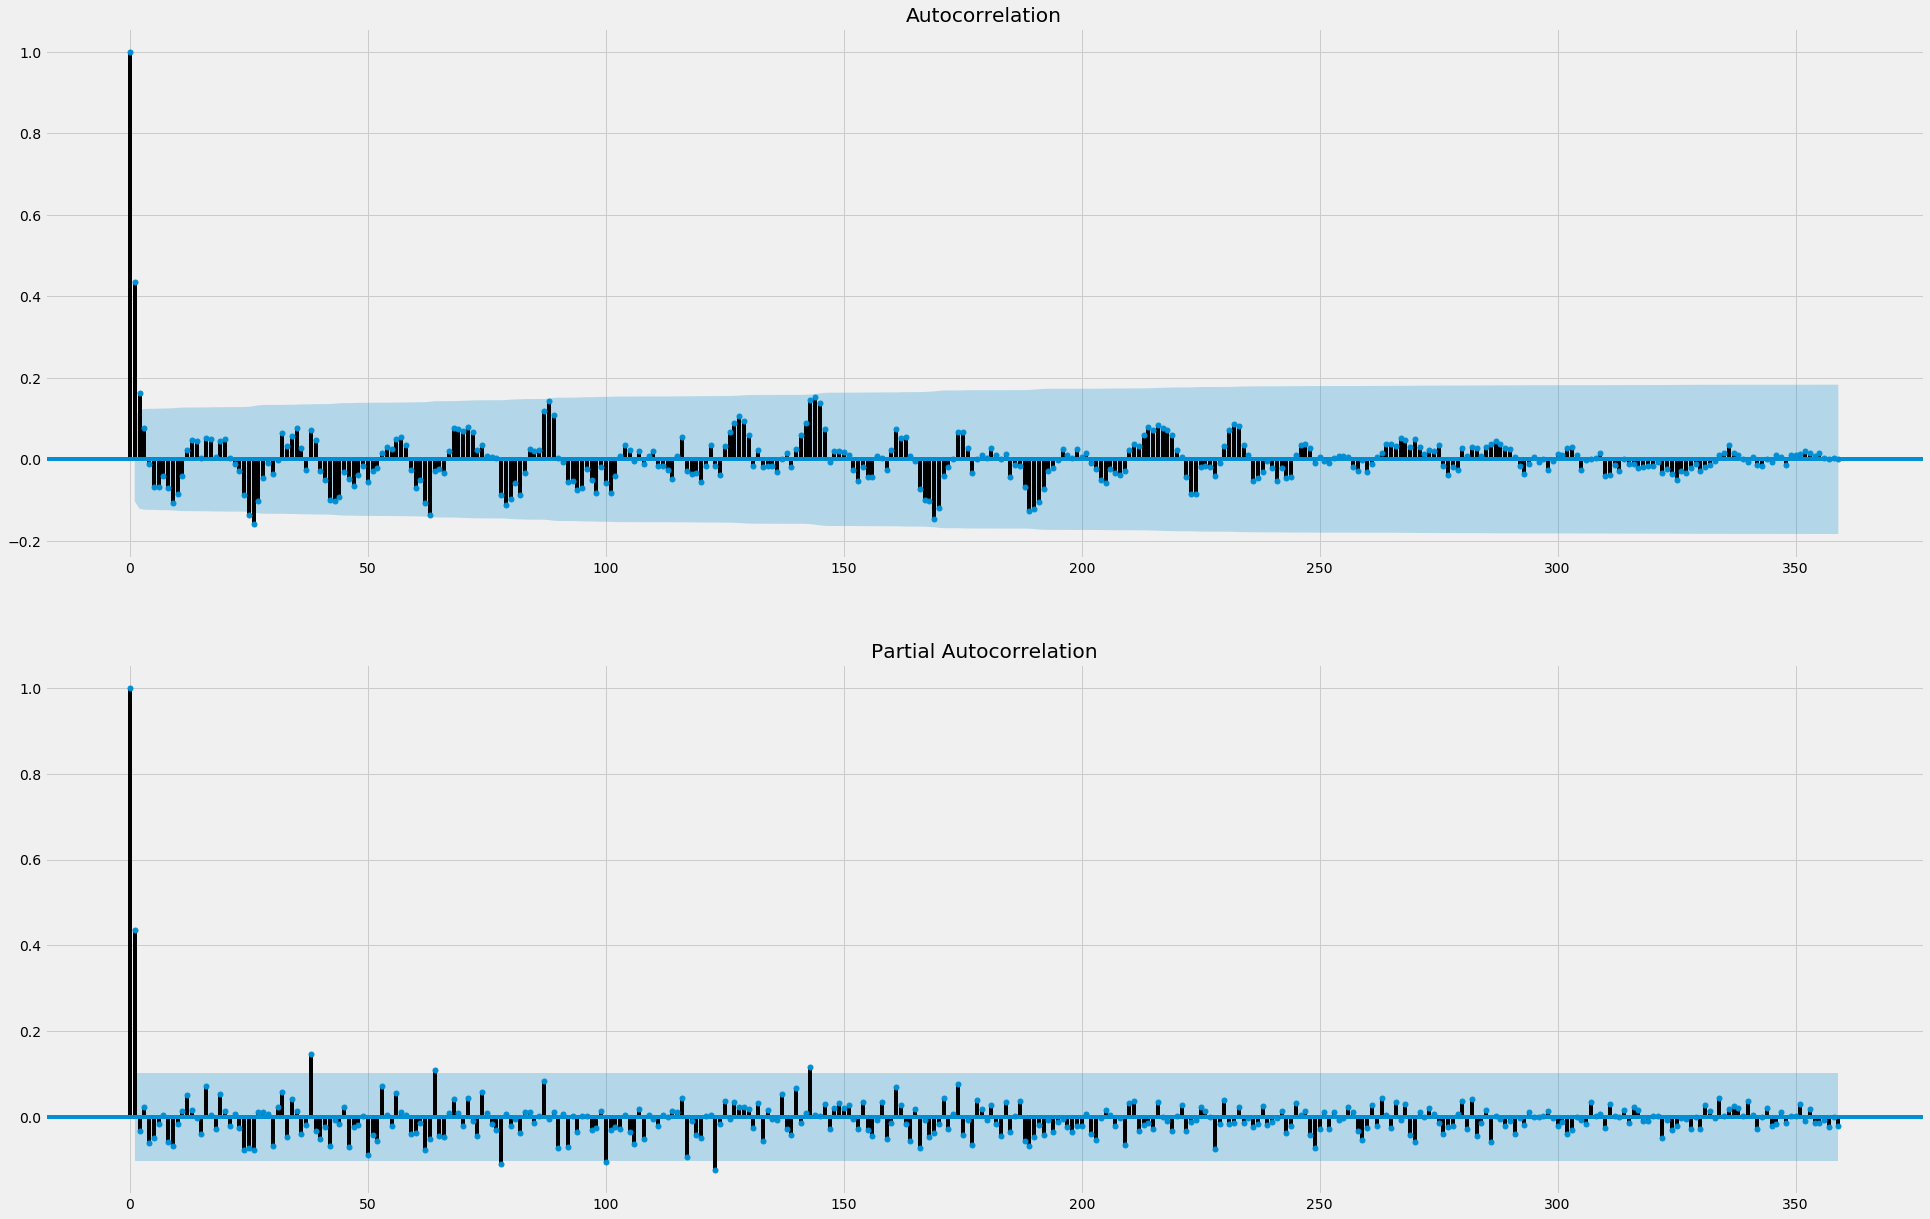

In [12]:
# plot
plt.figure(figsize=(30, 20))
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()


In [4]:
# validation the model

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

# load data
series = Series.from_csv('train.csv')
# prepare data
X = series.values
# difference data

# fit model
model = ARIMA(X, order=(5,0,3))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = -0.003716
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [5]:
# load and prepare datasets
dataset = Series.from_csv('train.csv')
history = [x for x in X]
validation = Series.from_csv('validation.csv')
y = validation
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[1])

yhat = bias + yhat
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f'  % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(5,0,3))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + yhat
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


>Predicted=0.293, Expected=0.690
>Predicted=0.572, Expected=0.350
>Predicted=0.218, Expected=0.290
>Predicted=0.127, Expected=-0.490
>Predicted=-0.511, Expected=-1.050
>Predicted=-1.101, Expected=-1.460
>Predicted=-1.473, Expected=-1.540
>Predicted=-1.558, Expected=-1.440
>Predicted=-1.442, Expected=-1.330
>Predicted=-1.291, Expected=-2.090
>Predicted=-1.874, Expected=-2.180
>Predicted=-2.037, Expected=-1.980
>Predicted=-1.802, Expected=-1.950
>Predicted=-1.741, Expected=-1.370
>Predicted=-1.270, Expected=-1.330
>Predicted=-1.131, Expected=-1.110
>Predicted=-0.942, Expected=-0.800
>Predicted=-0.609, Expected=-0.640
>Predicted=-0.424, Expected=-0.470
>Predicted=-0.297, Expected=-0.580
>Predicted=-0.413, Expected=-0.380
>Predicted=-0.307, Expected=-0.400
>Predicted=-0.306, Expected=-0.300
>Predicted=-0.252, Expected=-0.130
>Predicted=-0.095, Expected=0.020
>Predicted=0.055, Expected=0.360
>Predicted=0.359, Expected=0.200
>Predicted=0.271, Expected=0.260
>Predicted=0.267, Expected=0.320
>

>Predicted=-1.627, Expected=-1.170
>Predicted=-1.071, Expected=-0.890
>Predicted=-0.698, Expected=-0.640
>Predicted=-0.452, Expected=-0.440
>Predicted=-0.256, Expected=-0.040
>Predicted=0.095, Expected=-0.040
>Predicted=0.107, Expected=-0.280
>Predicted=-0.178, Expected=-0.300
>Predicted=-0.267, Expected=-0.370
>Predicted=-0.337, Expected=-0.900
>Predicted=-0.838, Expected=-1.000
>Predicted=-1.012, Expected=-0.710
>Predicted=-0.721, Expected=-0.720
>Predicted=-0.661, Expected=-0.250
>Predicted=-0.247, Expected=0.170
>Predicted=0.232, Expected=0.490
>Predicted=0.571, Expected=0.690
>Predicted=0.771, Expected=0.620
>Predicted=0.697, Expected=0.680
>Predicted=0.683, Expected=0.960
>Predicted=0.897, Expected=1.490
>Predicted=1.365, Expected=1.810
>Predicted=1.692, Expected=1.430
>Predicted=1.363, Expected=1.180
>Predicted=1.071, Expected=1.070
>Predicted=0.965, Expected=0.560
>Predicted=0.478, Expected=-0.150
>Predicted=-0.277, Expected=-0.620
>Predicted=-0.791, Expected=-0.890
>Predicted=

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f'% rmse)
plt.figure(figsize=(30, 20))
plt.plot(y.values)
plt.plot(predictions, color='red')
plt.title('Rolling-forecast Result')
plt.ylabel('Nino3.4 Index')
plt.xlabel('YEAR')
plt.legend(['observed', 'predict'], loc='upper left')
plt.show()

/Users/chengpeng/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


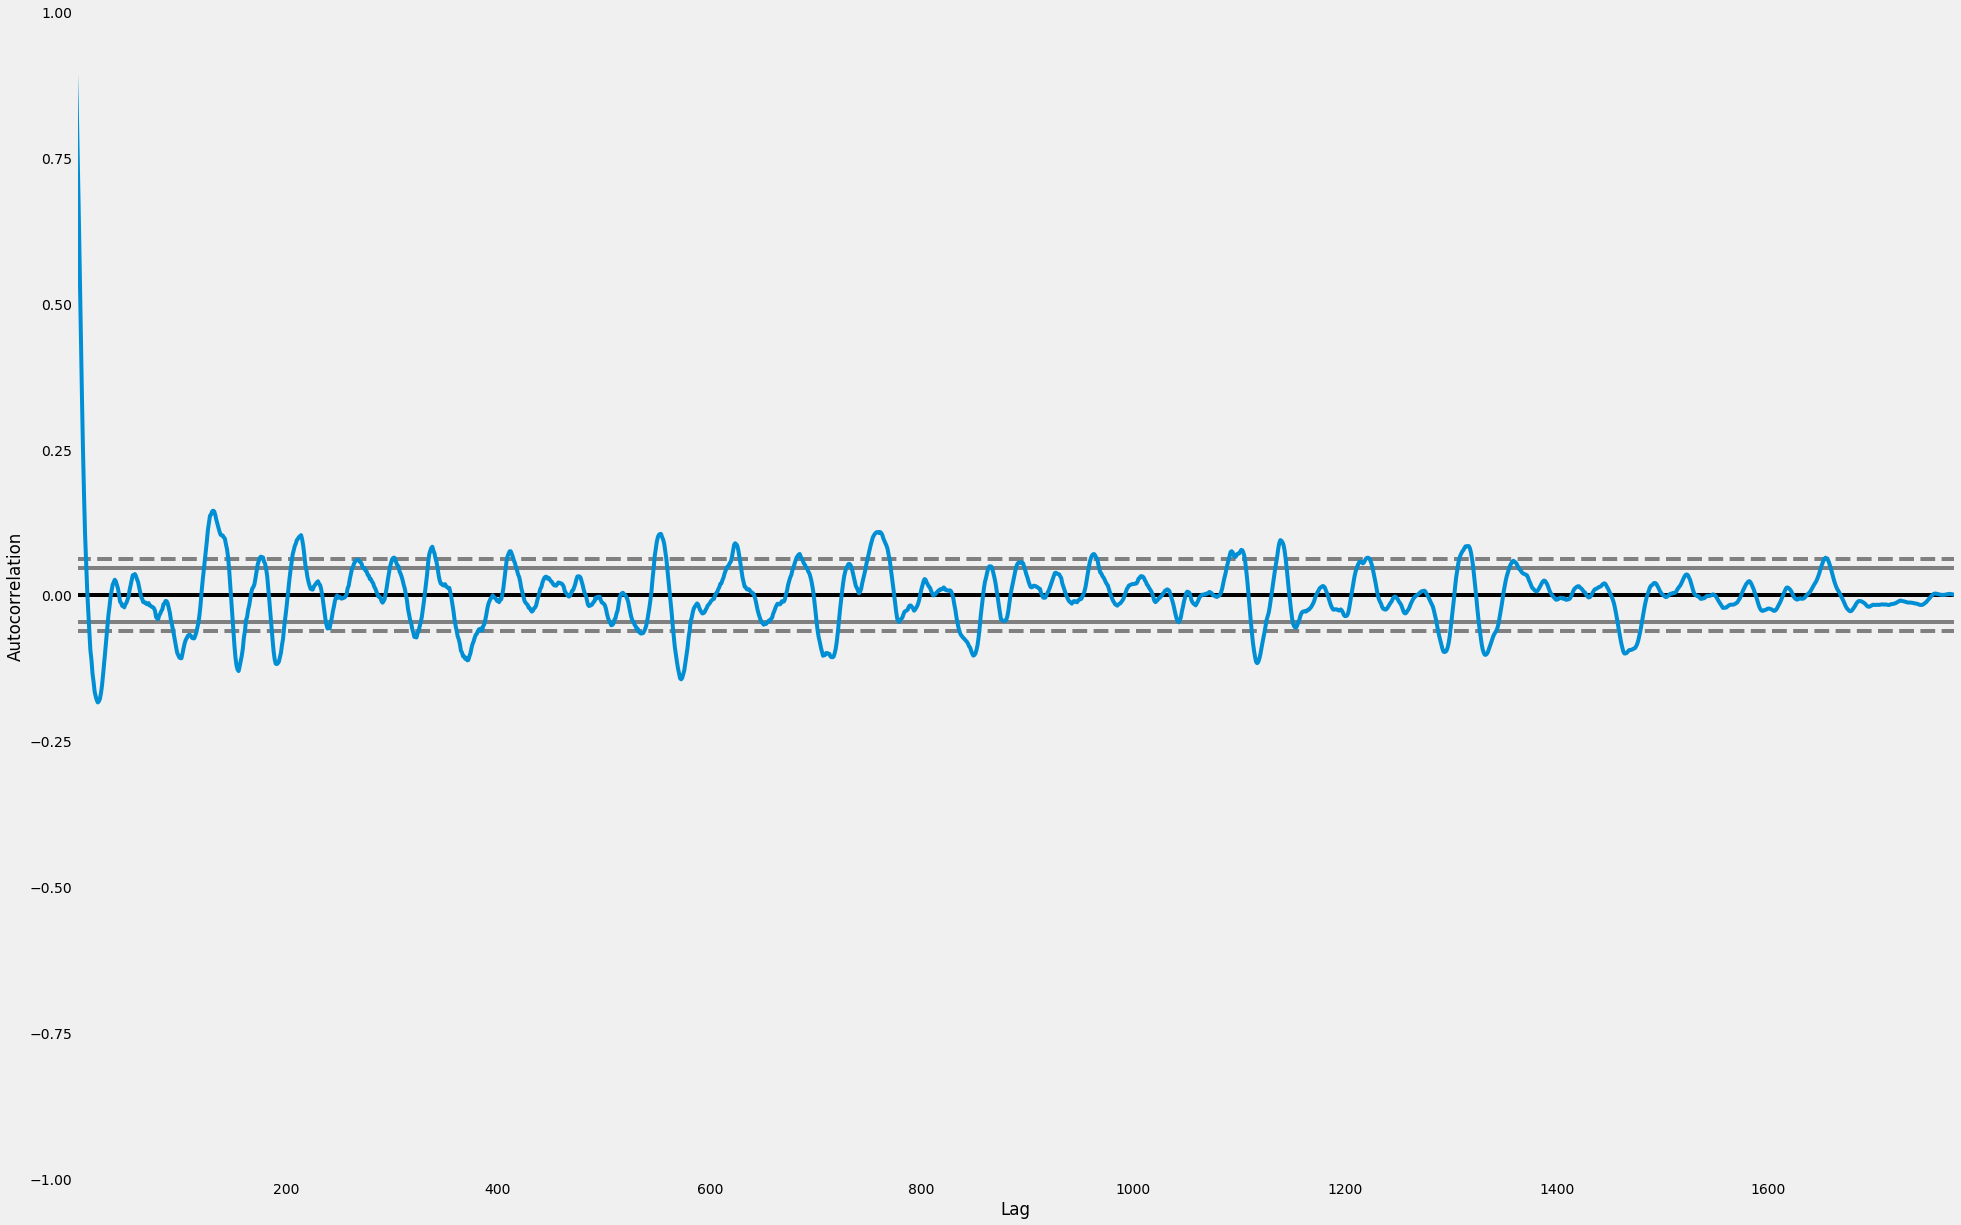

In [45]:
# other part
plt.figure(figsize=(30, 20))
autocorrelation_plot(series)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1775
Model:                ARIMA(11, 1, 0)   Log Likelihood                -343.137
Method:                       css-mle   S.D. of innovations              0.294
Date:                Fri, 20 Jul 2018   AIC                            712.274
Time:                        19:25:24   BIC                            783.535
Sample:                    02-01-1870   HQIC                           738.598
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.006      0.027      0.978      -0.012       0.012
ar.L1.D.y     -0.0360      0.024     -1.519      0.129      -0.083       0.010
ar.L2.D.y      0.1137      0.024      4.808      0.0

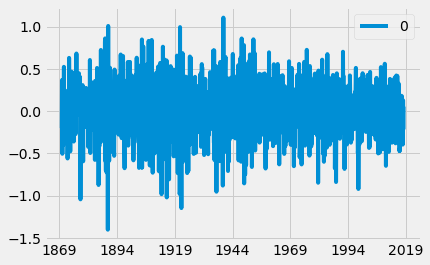

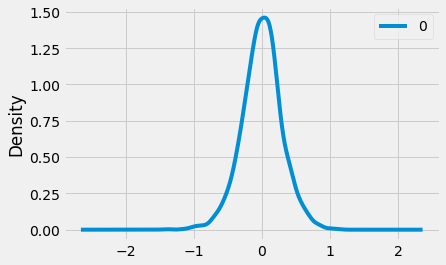

                 0
count  1775.000000
mean      0.000027
std       0.293656
min      -1.402076
25%      -0.181272
50%       0.005133
75%       0.177222
max       1.106164


In [9]:
model = ARIMA(series, order=(11,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
# print(residuals)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

/Users/chengpeng/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Test RMSE: 0.261


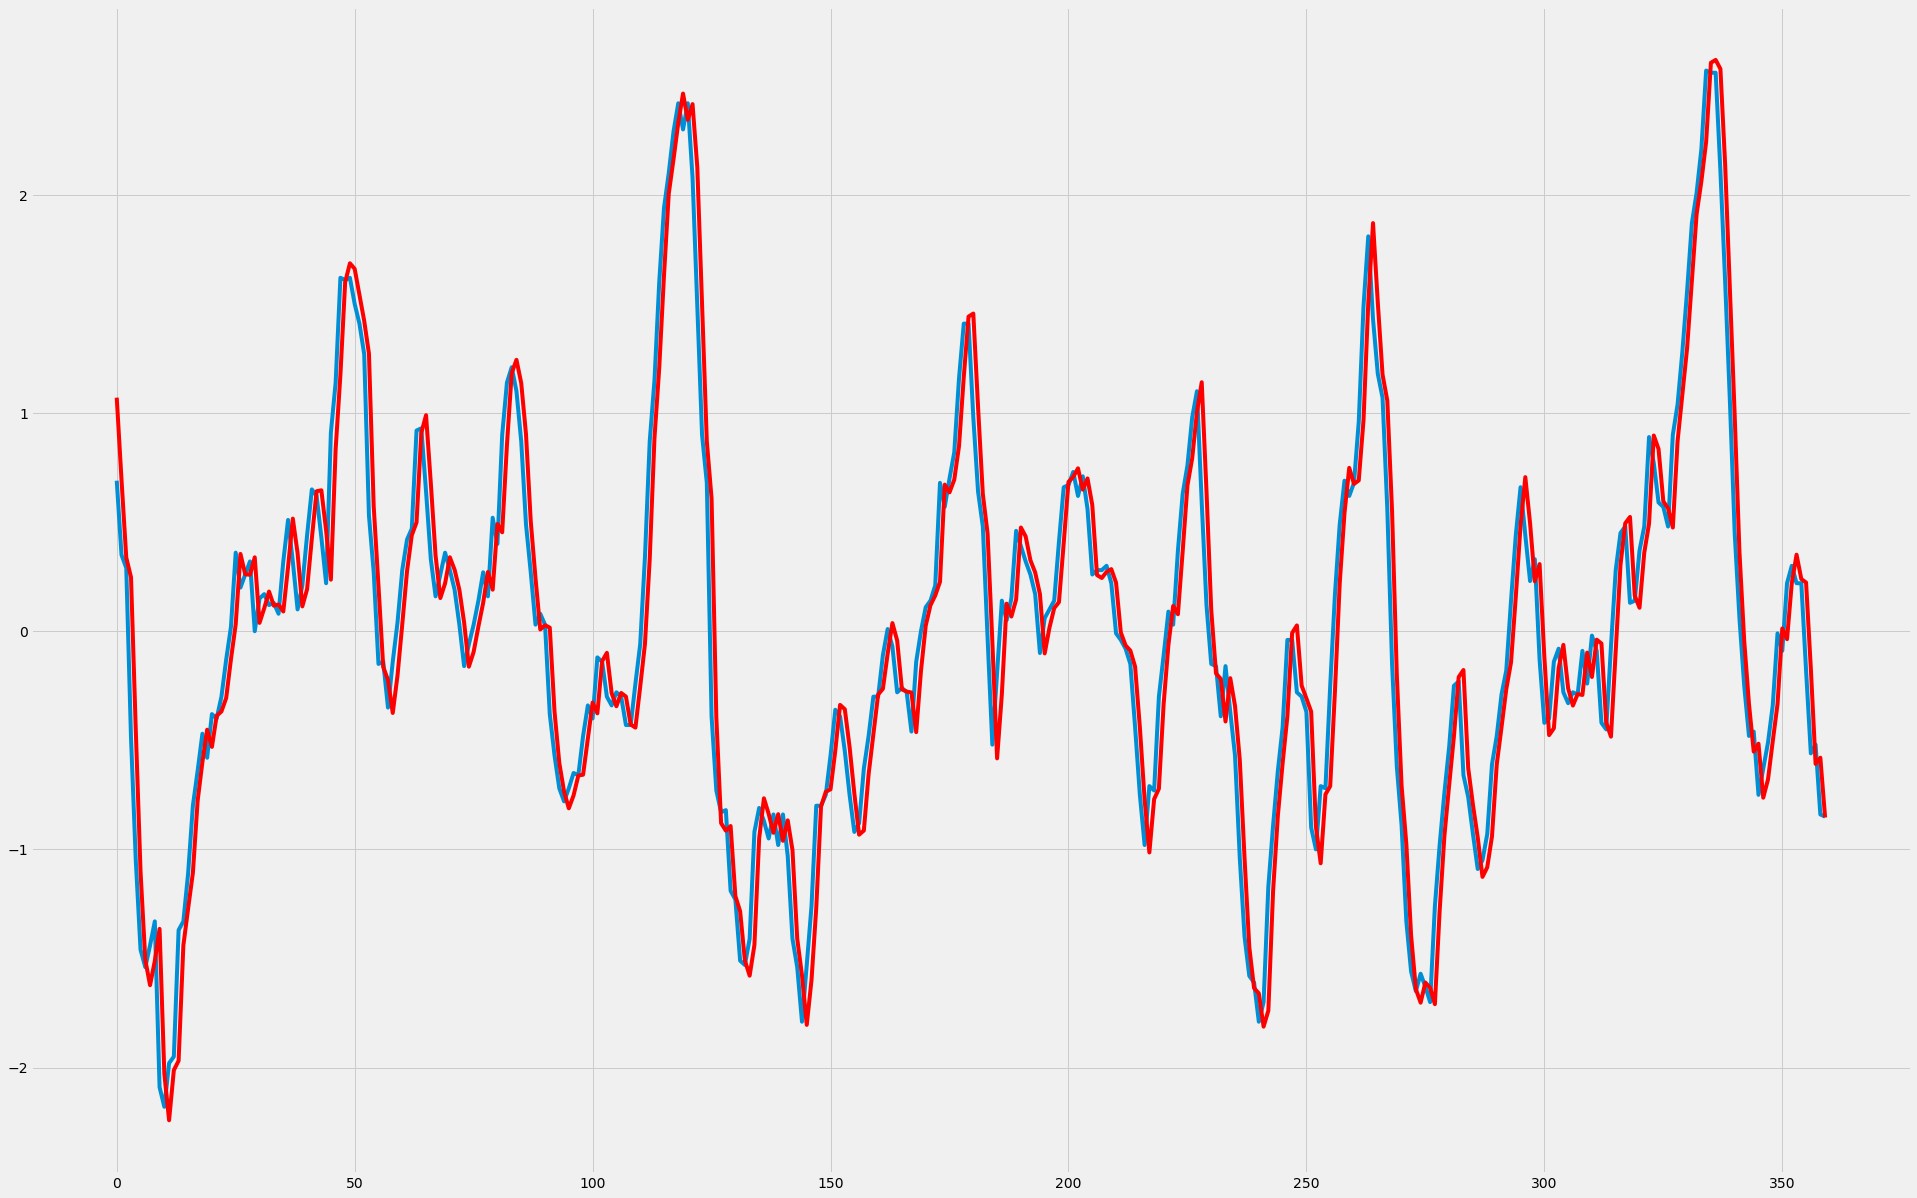

In [95]:
series = pd.Series.from_csv('../../data/oni/csv/nino34_anomaly.csv')
plt.figure(figsize=(30, 20))
# series = series.values
# print(series)
train, test = series[0:-360], series[-360:len(series)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

# plot
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

In [96]:
# persistence model (naive model)
train, test = series[0:-360], series[-360:len(series)]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print( ">Predicted=%.3f, Expected=%.3f"  % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print( "RMSE: %.3f"  % rmse)

>Predicted=1.050, Expected=0.690
>Predicted=0.690, Expected=0.350
>Predicted=0.350, Expected=0.290
>Predicted=0.290, Expected=-0.490
>Predicted=-0.490, Expected=-1.050
>Predicted=-1.050, Expected=-1.460
>Predicted=-1.460, Expected=-1.540
>Predicted=-1.540, Expected=-1.440
>Predicted=-1.440, Expected=-1.330
>Predicted=-1.330, Expected=-2.090
>Predicted=-2.090, Expected=-2.180
>Predicted=-2.180, Expected=-1.980
>Predicted=-1.980, Expected=-1.950
>Predicted=-1.950, Expected=-1.370
>Predicted=-1.370, Expected=-1.330
>Predicted=-1.330, Expected=-1.110
>Predicted=-1.110, Expected=-0.800
>Predicted=-0.800, Expected=-0.640
>Predicted=-0.640, Expected=-0.470
>Predicted=-0.470, Expected=-0.580
>Predicted=-0.580, Expected=-0.380
>Predicted=-0.380, Expected=-0.400
>Predicted=-0.400, Expected=-0.300
>Predicted=-0.300, Expected=-0.130
>Predicted=-0.130, Expected=0.020
>Predicted=0.020, Expected=0.360
>Predicted=0.360, Expected=0.200
>Predicted=0.200, Expected=0.260
>Predicted=0.260, Expected=0.320
>